

<br>
<br>


<h1><center> SFS </center></h1>


<br>
<br>


#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>
<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>
<br>


#### Contents


1. **[Setup](#Setup)**
2. **[Imports and Definitions](#Imports-and-Definitions)**
3. **[Detector Definition](#Detector-Definition)**
4. **[Spectra Definition](#Spectra-Definition)**
5. **[Executing NEST](#Executing-NEST)**
6. **[ER/NR Discrimination](#ER/NR-Discrimination)**
7. **[Maximum Likelihood Sensitivity Estimation](#Maximum-Likelihood-Sensitivity-Estimation)**


<br>
<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>
<br>


# Setup


<br>
<br>


- install NEST following their official documentation


- Store the absolute path of the NEST installation, i.e., the directory containing the `nest`, `install`, and `build` directories, in an environmental variable. Therefore execute:<br> `$ echo 'export ABSPATH_NEST_INSTALLATION="/abspath/to/your/nest/root/directory/" >> ~/.bashrc'`


- git clone the ''sfsv2'' repository


- edit the ''sfs.py'' file


<br>
<br>



<br>
<br>


# Imports and Definitions


<br>
<br>


#### paths

In [1]:


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]
abspath_signatures = abspath_study +"signatures/"
abspath_discrimination_lines = abspath_study +"discrimination_lines/"
abspath_test = abspath_study +"test/"
abspath_er_leakage_study = abspath_study +"20230519__er_leakage_study/"


#### imports

In [2]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import time
from datetime import timedelta
import datetime



# importing my personal matplotlib style file
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs


#### study assumptions

In [3]:


# default study parameters
default_wimp_eroi_kev_ee = [1.0, 12.0] # WIMP energy region of interest in keV_ee
default_wimp_eroi_kev_nr = [5.0, 55.0] # WIMP energy region of interest in keV_nr
default_wimp_mass_gev = 100 # WIMP mass in GeV
default_wimp_nucleon_cross_section_cm2 = 5e-49 # WIMP-nucleon cross-section in cm^2


# default study settings
default_number_of_medium_stat_simulations = 5*10**5 # number of events simulated in medium statistics simulations
default_number_of_high_stat_simulations = 5*10**6 # number of events simulated in high statistics simulations
default_simulation_energy_bins = 50 # number of energy bins used for the spectra simulation
default_recoil_energy_simulation_window_er = [0.8, default_wimp_eroi_kev_ee[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_recoil_energy_simulation_window_nr = [2.5, default_wimp_eroi_kev_nr[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_number_of_discrimination_line_energy_bins = 50 # number of energy bins into which the WIMP EROI is subdivided for the computation of the ER rejection
default_nr_acceptance = 0.50 # acceptance of the (not in percent) of the nuclear recoils on which the NR computation is based




<br>
<br>


# DARWIN Baseline Detector Definition


<br>
<br>


In [4]:


# defining the 'detector_dict'
darwin_baseline_detector_dict = {
    # primary scintillation (S1) parameters
    "g1"                : 0.125,                    # phd per S1 phot at dtCntr (not phe), divide out 2-PE effect,                          JN: 0.119, LUX_Run03: 0.1170 (0.117+/-0.003 WS,0.115+/-0.005 D-D,0.115+/-0.005 CH3T,0.119+/-0.001 LUXSim), XENON10: 0.073
    "sPEres"            : 0.35,                     # single phe (=PE=photoelectrons) resolution (Gaussian assumed),                        JN: 0.38, LUX_Run03: 0.37 (arXiv:1910.04211.), XENON10: 0.58
    "sPEthr"            : 0.35,                     # POD threshold in phe, usually used IN PLACE of sPEeff,                                JN: 0.35, LUX_Run03: (0.3 * 1.173) / 0.915 (arXiv:1910.04211.), XENON10: 0.35
    "sPEeff"            : 1.0,                      # actual efficiency, can be used in lieu of POD threshold, units: fractional,           JN: 0.90, LUX_Run03: 1.00 (arXiv:1910.04211), XENON10: 1.00
    "noiseBaseline[0]"  : 0.0,                      # baseline noise mean in PE (Gaussian),                                                 JN: 0.0, LUX_Run03: 0.00 (arXiv:1910.04211 says -0.01), XENON10: 0.0
    "noiseBaseline[1]"  : 0.0,                      # baseline noise width in PE (Gaussian),                                                JN: 0.0, LUX_Run03: 0.08 (arXiv:1910.04211), XENON10: 0.0
    "noiseBaseline[2]"  : 0.0,                      # baseline noise mean in e- (for grid wires),                                           JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "noiseBaseline[3]"  : 0.0,                      # baseline noise width in e- (for grid wires),                                          JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "P_dphe"            : 0.2,                      # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT, units: fractional,         JN: 0.22, LUX_Run03: 0.173 (arXiv:1910.04211), XENON10: 0.2
    "coinWind"          : 150,                      # S1 coincidence window in ns,                                                          JN: 100, LUX_Run03: 100 (1310.8214), XENON10: 100
    "coinLevel"         : 3,                        # how many PMTs have to fire for an S1 to count,                                        JN: 3, LUX_Run03: 2 (1512.03506), XENON10: 2
    "numPMTs"           : 494,                      # for coincidence calculation,                                                          JN: 494, LUX_Run03: 119 (122 minus 3 off), XENON10: 89
    "OldW13eV"          : "true",                   # default true, which means use "classic" W instead of Baudis / EXO's,                  JN: none, LUX_Run03: "true", XENON10: "true"
    "noiseLinear[0]"    : 0.0e-2,                   # S1->S1 Gaussian-smeared with noiseL[0]*S1, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    "noiseLinear[1]"    : 0.0e-2,                   # S2->S2 Gaussian-smeared with noiseL[1]*S2, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    # ionization and secondary scintillation (S2) parameters
    "g1_gas"            : 0.125,                    # phd per S2 photon in gas, used to get SE size, units: phd per e-,                     JN: 0.102, LUX_Run03: 0.1 (0.1 in 1910.04211), XENON10: 0.0655
    "s2Fano"            : 2.0,                      # Fano-like fudge factor for SE width, dimensionless,                                   JN: 3.61, LUX_Run03: 3.6 (3.7 in 1910.04211; this matches 1608.05381 better), XENON10: 3.61
    "s2_thr"            : 100,                      # the S2 threshold in phe or PE, *not* phd. Affects NR most,                            JN: 100.0, LUX_Run03: (150.0 * 1.173) / 0.915 (65-194 pe in 1608.05381), XENON10: 300.0
    "E_gas"             : 7.0,                      # field in kV/cm between liquid/gas border and anode,                                   JN: 10.85, LUX_Run03: 6.25 (6.55 in 1910.04211), XENON10: 12.0
    "eLife_us"          : 10000.0,                  # the drift electron mean lifetime in micro-seconds,                                    JN: 1600.0, LUX_Run03: 800.0 (p.44 of James Verbus PhD thesis Brown), XENON10: 2200.0
    # thermodynamic properties
#    "inGas"             : "false",                  # (duh),                                                                               JN: "false", LUX_Run03: commented out, XENON10: "false"
    "T_Kelvin"          : 175.0,                    # for liquid drift speed calculation, temperature in Kelvin,                            JN: 175.0, LUX_Run03: 173.0 (1910.04211), XENON10: 177.0
    "p_bar"             : 1.9,                      # gas pressure in units of bars, it controls S2 size,                                   JN: 2.0, LUX_Run03: 1.57 (1910.04211), XENON10: 2.14
    # data analysis parameters and geometry
    "dtCntr"            : 900.0,                    # center of detector for S1 corrections, in usec.,                                      JN: 822.0, LUX_Run03: 160.0 (p.61 Dobi thesis UMD, 159 in 1708.02566), XENON10: 40.0
    "dt_min"            : 100.0,                    # minimum. Top of detector fiducial volume, units: microseconds,                        JN: 75.8, LUX_Run03: 38.0 (1608.05381), XENON10: 20.0
    "dt_max"            : 1700.0,                   # maximum. Bottom of detector fiducial volume, units: microseconds,                     JN: 1536.5, LUX_Run03: 305.0 (1608.05381), XENON10: 60.0
    "radius"            : 1250.0,                   # millimeters (fiducial rad), units: millimeters,                                       JN: 1300., LUX_Run03: 200.0 (1512.03506), XENON10: 50.0
    "radmax"            : 1300.0,                   # actual physical geo. limit, units: millimeters,                                       JN: 1350., LUX_Run03: 235.0 (1910.04211), XENON10: 50.0
    "TopDrift"          : 2650.0,                   # top of drift volume in mm not cm or us, i.e., this *is* where dt=0, z=0mm is cathode,  JN: 3005.0, LUX_Run03: 544.95 (544.95 in 1910.04211), XENON10: 150.0
    "anode"             : 2657.0,                   # the level of the anode grid-wire plane in mm,                                         JN: 3012.5, LUX_Run03: 549.2 (1910.04211 and 549 in 1708.02566), XENON10: 152.5
    "gate"              : 2643.0,                   # mm. this is where the E-field changes (higher),                                       JN: 3000.0, LUX_Run03: 539.2 (1910.04211 and 539 in 1708.02566), XENON10: 147.5
    "cathode"           : 50.0,                     # mm. defines point below which events are gamma-X                                      JN: 250, LUX_Run03: 55.90 (55.9-56 in 1910.04211,1708.02566), XENON10: 1.00
    # 2D (xy) position reconstruction
    "PosResExp"         : 0.015,                    # exp increase in pos recon res at hi r, units: 1/mm,                                   JN: 0.015, LUX_Run03: 0.015 (arXiv:1710.02752 indirectly), XENON10: 0.015
    "PosResBase"        : 30.,                      # baseline unc in mm, see NEST.cpp for usage,                                           JN: 30.0, LUX_Run03: 70.8364 ((1710.02752 indirectly), XEONON10: 70.8364
}



# non-NEST detector parameters
darwin_baseline_detector_drift_field_v_cm = 200 # drift field of the darwin baseline design in V/cm
darwin_baseline_detector_runtime_y = 5 # live time of the experiment in years
darwin_baseline_detector_fiducial_mass_t = 30 # fiducial volume of the detector in metric tonnes


# adjusting drift times according to detector dimension
darwin_baseline_detector_dict = sfs.adjust_detector_drift_time_parameters(darwin_baseline_detector_dict, darwin_baseline_detector_drift_field_v_cm)


# saving the 'detector_dict' of the darwin baseline detector
sfs.write_dict_to_json(abspath_detectors +"example__detector__darwin_baseline_detector.json", darwin_baseline_detector_dict)


# derived parameters
darwin_baseline_detector_g2 = sfs.compute_g2_from_detector_configuration(darwin_baseline_detector_dict)
print(f"g2: {darwin_baseline_detector_g2} phd per primary electron")
darwin_baseline_detector_drift_velocity_mm_usec = sfs.compute_drift_velocity_from_detector_configuration(darwin_baseline_detector_dict,darwin_baseline_detector_drift_field_v_cm)
print(f"drift velocity: {darwin_baseline_detector_drift_velocity_mm_usec} mm/usec")
darwin_baseline_detector_active_xenon_mass_t = sfs.calc_active_xenon_mass_of_detector_dict_t(darwin_baseline_detector_dict)
print(f"active xenon mass: {darwin_baseline_detector_active_xenon_mass_t} tonnes")
max_drift_time_usec = (darwin_baseline_detector_dict['TopDrift']-darwin_baseline_detector_dict['cathode'])/darwin_baseline_detector_drift_velocity_mm_usec
print(f"max drift time: {max_drift_time_usec} usec")
darwin_baseline_detector_fiducial_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_fiducial_mass_t
print(f"fiducial exposure: {darwin_baseline_detector_fiducial_exposure_ty} ty")
darwin_baseline_detector_active_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_active_xenon_mass_t
print(f"active exposure: {darwin_baseline_detector_active_exposure_ty} ty")



g2: 14.963110989324022 phd per primary electron
drift velocity: 1.5248620549967127 mm/usec
active xenon mass: 40.449157162641384 tonnes
max drift time: 1705.0722663602546 usec
fiducial exposure: 150 ty
active exposure: 202.2457858132069 ty



<br>
<br>


# Spectra Definition


<br>
<br>



#### plot differential ER and NR backgrounds
WIMPs are computed with [Jelle Aalber's `wimprates` library](https://github.com/JelleAalbers/wimprates).

In [5]:


if [False,True][0]:


    if [False,True][1]:
        sfs.gen_spectrum_plot(
            spectra_list = ["er_pp", "er_be7" , "er_nunubetabeta", "combined_er_background", "er_rn222", "er_rn222_1ubqpkg"],
            abspath_spectra_files = abspath_resources,
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][2],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [1,100],
            plot_ylim = [1e-1,1e+2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.15, 0.55, 0.25, 0.45],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
#            flag_output_abspath_list = [],
            flag_output_filename = "example__spectrum_plot__differential_combined_er_background.png",
            flag_shade_wimp_eroi = default_wimp_eroi_kev_ee,
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][1], )


    if [False,True][0]:
        sfs.gen_spectrum_plot(
            #spectra_list = ["nr_wimps_nat_xe", "nr_wimps_wimprates", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            #spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_34t", "nr_neutrons_28t", "nr_neutrons_20t", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_new_baseline", "nr_neutrons_new_improved_ptfe_and_pmts_and_cryo", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb"],
            abspath_spectra_files = abspath_resources,
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            },
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][1],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [2,100],
        #        plot_ylim = [3e-5,2e-1],
            plot_ylim = [1e-4,1e-2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.60, 0.35, 0.38, 0.73],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
        #        flag_output_abspath_list = [],
            flag_shade_wimp_eroi = default_wimp_eroi_kev_nr,
            flag_output_filename = "example__spectrum_plot__differential_combined_nr_background_wimps.pdf",
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][2], )



#### histogrammed ER and NR background spectra

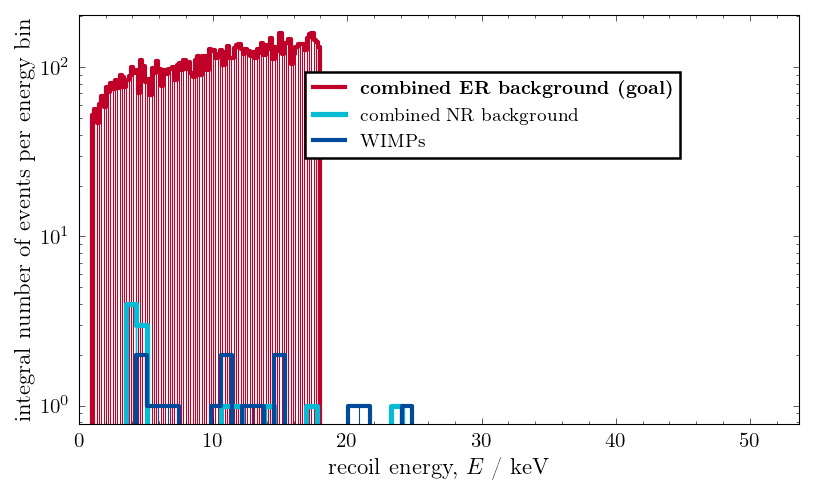

In [6]:


if [False,True][1]:


    if [False,True][0]:


        # generating the ER background spectrum dict
        er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = 1,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background.json", er_background_spectrum_dict)


        # generating the ER background spectrum dict with medium statistics
        high_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json", high_statistics_er_background_spectrum_dict)


        # generating the ER background spectrum dict with high statistics
        #high_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
        #    spectrum_name = "combined_er_background",
        #    recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
        #    # 
        #    abspath_spectra_files = abspath_resources,
        #    exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
        #    num_events = default_number_of_high_stat_simulations,
        #    # nest parameters
        #    seed = randrange(10000001),
        #    drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        #    xyz_pos_mm = "-1",
        #    # flags
        #    flag_spectrum_type = ["differential", "integral"][1],
        #    flag_verbose = False,)
        #sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json", high_statistics_er_background_spectrum_dict)


        # generating the NR background spectrum dict
        nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_rounded",
            # nest parameters
            seed = 2,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background.json", nr_background_spectrum_dict)


        # generating the NR background spectrum dict with medium statistics
        medium_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json", high_statistics_nr_background_spectrum_dict)


        # generating the NR background spectrum dict with high statistics
        #high_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
        #    spectrum_name = "combined_nr_background",
        #    recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
        #    # 
        #    abspath_spectra_files = abspath_resources,
        #    exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
        #    num_events = default_number_of_high_stat_simulations,
        #    # nest parameters
        #    seed = randrange(10000001),
        #    drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        #    xyz_pos_mm = "-1",
        #    # flags
        #    flag_spectrum_type = ["differential", "integral"][1],
        #    flag_verbose = False,)
        #sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json", high_statistics_nr_background_spectrum_dict)


        # generating the WIMP spectrum dict
        wimp_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "nr_wimps_wimprates",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_rounded",
            # nest parameters
            seed = 3,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            }
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__wimps.json", wimp_spectrum_dict)


    else:


        er_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json")
        nr_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json")
        wimp_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json")


    # plotting the spectra the simulation is fed with (as would be expected in a realistic DARWIN detector)
    sfs.gen_spectrum_plot(
        spectra_list = [er_background_spectrum_dict, nr_background_spectrum_dict, wimp_spectrum_dict],
        abspath_spectra_files = abspath_resources,
        #spectra_list = [nr_test_spectrum_dict],
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        plot_log_y_axis = True,
        plot_log_x_axis = False,
        plot_xlim = [0,default_recoil_energy_simulation_window_nr[1]*0.65],
        plot_ylim = [],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][0],
        plot_legend = True,
        plot_legend_bbox_to_anchor = [0.45, 0.63, 0.25, 0.25],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 9,
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__integral_combined_er_nr_spectra_wimps.png",
        flag_shade_wimp_eroi = [],
        flag_verbose = False,)




<br>
<br>


# Executing NEST


<br>
<br>


#### executing NEST to generate signature ndarrays

In [7]:


if [False,True][1]:


    er_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
        #{ # one can specify only a few parameters that will be overwritten in 'baseline_detector_dict'
        #    "g1"       : 0.15,
        #},
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy", er_background_ndarray)


    medium_statistics_er_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {},
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy", medium_statistics_er_background_ndarray)


    #high_statistics_er_background_ndarray = sfs.execNEST(
    #    spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
    #    baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
    #    baseline_detector_dict = darwin_baseline_detector_dict,
    #    detector_dict = {},
    #    detector_name = "example__detector__darwin_baseline_detector",
    #    abspath_list_detector_dict_json_output = [abspath_detectors],
    #    flag_verbose = True,
    #    flag_print_stdout_and_stderr = False,)
    #np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_high_stat.npy", high_statistics_er_background_ndarray)


    nr_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {}, # an empty 'detector_dict' will use the installed detector
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy", nr_background_ndarray)


    medium_statistics_nr_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy", medium_statistics_nr_background_ndarray)


    #high_statistics_nr_background_ndarray = sfs.execNEST(
    #    spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
    #    baseline_detector_dict = darwin_baseline_detector_dict,
    #    baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
    #    detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
    #    detector_name = "example__detector__darwin_baseline_detector",
    #    abspath_list_detector_dict_json_output = [abspath_detectors],
    #    flag_verbose = True,
    #   flag_print_stdout_and_stderr = False,)
    #np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_high_stat.npy", high_statistics_nr_background_ndarray)


    wimp_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        detector_dict = {},
        detector_name = "example__detector__darwin_baseline_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_test_detector__wimps.npy", wimp_ndarray)




execNEST: initializing
execNEST: specified detector 'example__detector__darwin_baseline_detector'as dictionary: {'g1': 0.125, 'sPEres': 0.35, 'sPEthr': 0.35, 'sPEeff': 1.0, 'noiseBaseline[0]': 0.0, 'noiseBaseline[1]': 0.0, 'noiseBaseline[2]': 0.0, 'noiseBaseline[3]': 0.0, 'P_dphe': 0.2, 'coinWind': 150, 'coinLevel': 3, 'numPMTs': 494, 'OldW13eV': 'true', 'noiseLinear[0]': 0.0, 'noiseLinear[1]': 0.0, 'g1_gas': 0.125, 's2Fano': 2.0, 's2_thr': 100, 'E_gas': 7.0, 'eLife_us': 10000.0, 'T_Kelvin': 175.0, 'p_bar': 1.9, 'dtCntr': 852.5, 'dt_min': 170.5, 'dt_max': 1534.6, 'radius': 1250.0, 'radmax': 1300.0, 'TopDrift': 2650.0, 'anode': 2657.0, 'gate': 2643.0, 'cathode': 50.0, 'PosResExp': 0.015, 'PosResBase': 30.0}
execNEST: updating baseline detector

convert_detector_dict_into_detector_header: initializing
	detector_name: example__detector__darwin_baseline_detector
convert_detector_dict_into_detector_header: adding initial lines to 'line_list'.
convert_detector_dict_into_detector_header: add

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 213 out of 213 events
extracting the wanted number of events
execNEST: executing '$ execNEST 243 ER 2.4450000000000003 2.4450000000000003 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 243 out of 243 events
extracting the wanted number of events
execNEST: executing '$ execNEST 222 ER 2.615 2.615 200 -1 1'
	checking implemented detector
	imp

	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 330 out of 330 events
extracting the wanted number of events
execNEST: executing '$ execNEST 306 ER 4.825 4.825 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1

	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 294 out of 294 events
extracting the wanted number of events
execNEST: executing '$ execNEST 294 ER 6.865 6.865 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 264 out of 264 events
extracting the wanted number of events
execNEST: executing '$ execNEST 330 ER 8.735000000000001 8.735000000000001 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 330 out of 330 events
extracting the wanted number of events
execNEST: executing '$ execNEST 348 ER 8.905000000000001 8.905000000000001 200 -1 1'
	checking imp

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 309 out of 309 events
extracting the wanted number of events
execNEST: executing '$ execNEST 369 ER 10.945000000000002 10.945000000000002 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 369 out of 369 events
extracting the wanted number of events
execNEST: executing '$ execNEST 402 ER 11.115000000000002 11.115000000000002 200 -1 1'
	checking

	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 351 out of 351 events
extracting the wanted number of events
execNEST: executing '$ execNEST 369 ER 12.985000000000001 12.985000000000001 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,

	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 375 out of 375 events
extracting the wanted number of events
execNEST: executing '$ execNEST 477 ER 15.025000000000002 15.025000000000002 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,

	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 378 out of 378 events
extracting the wanted number of events
execNEST: executing '$ execNEST 447 ER 17.065 17.065 200 -1 1'
	checking implemented detector
	implemented detector = 'example__detector__darwin_baseline_detector' = 'example__detector__darwin_baseline_detector' = specified detector
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', '

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 7481 out of 7488 events
extracting the wanted number of events
execNEST: executing '$ execNEST 7857 ER 2.2750000000000004 2.2750000000000004 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 7855 out of 7857 events
e

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 9876 out of 9876 events
extracting the wanted number of events
execNEST: executing '$ execNEST 10011 ER 4.825 4.825 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 10011 out of 10011 events
extracting the wanted nu

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 10953 out of 10953 events
extracting the wanted number of events
execNEST: executing '$ execNEST 10860 ER 7.375 7.375 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 10860 out of 10860 events
extracting the wanted 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 12306 out of 12306 events
extracting the wanted number of events
execNEST: executing '$ execNEST 12840 ER 9.925 9.925 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 12840 out of 12840 events
extracting the wanted 

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 13470 out of 13470 events
extracting the wanted number of events
execNEST: executing '$ execNEST 13395 ER 12.305000000000001 12.305000000000001 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 13395 out of 13395 events
extracting the wanted number of events
execNEST: executing '$ execNEST 14166 ER 12.475000000000001 12.475000000000001 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II:

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 14688 out of 14688 events
extracting the wanted number of events
execNEST: executing '$ execNEST 14466 ER 14.855000000000002 14.855000000000002 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 14466 out of 14466 eve

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 15108 out of 15108 events
extracting the wanted number of events
execNEST: executing '$ execNEST 15225 ER 17.405 17.405 200 -1 6158392'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 15225 out of 15225 events
extracting the wante

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 75582 out of 76689 events
extracting the wanted number of events
execNEST: executing '$ execNEST 66807 NR 6.265000000000001 6.265000000000001 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 66396 out of 66807 events
extracting the wanted number of events
execNEST: executing '$ execNEST 60411 NR 7.055 7.055 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 27207 out of 27207 events
extracting the wanted number of events
execNEST: executing '$ execNEST 25779 NR 18.115 18.115 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 25779 out of 25779 events
extracting the wanted number of events
execNEST: executing '$ execNEST 23787 NR 18.905 18.905 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr'

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 11757 out of 11757 events
extracting the wanted number of events
execNEST: executing '$ execNEST 11202 NR 29.965 29.965 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 11202 out of 11202 events
extracting the wanted number of events
execNEST: executing '$ execNEST 11490 NR 30.755 30.755 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr'

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 5274 out of 5274 events
extracting the wanted number of events
execNEST: executing '$ execNEST 4932 NR 42.605000000000004 42.605000000000004 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 4932 out of 4932 events
e

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 2463 out of 2463 events
extracting the wanted number of events
execNEST: executing '$ execNEST 2403 NR 54.455000000000005 54.455000000000005 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 2403 out of 2403 events
e

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 894 out of 894 events
extracting the wanted number of events
execNEST: executing '$ execNEST 1044 NR 66.30499999999999 66.30499999999999 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1044 out of 1044 events
extra

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 297 out of 297 events
extracting the wanted number of events
execNEST: executing '$ execNEST 252 NR 79.735 79.735 200 -1 6677324'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 252 out of 252 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events


#### Checking the Statistics of the Signatures

In [8]:


if [False,True][0]:


    arrays = {
        "ER" : [
            "example__signature__darwin_baseline_detector__er_background.npy",
            "example__signature__darwin_baseline_detector__er_background_medium_stat.npy",
            "example__signature__darwin_baseline_detector__er_background_high_stat.npy",
        ],
        "NR" : [
            "example__signature__darwin_baseline_detector__nr_background.npy",
            "example__signature__darwin_baseline_detector__nr_background_medium_stat.npy",
            "example__signature__darwin_baseline_detector__nr_background_high_stat.npy",
        ],
    }



    for it in ["ER", "NR"]:
        for k, stats in enumerate(["", "medium_stat", "high_stats"]):
            ndarray = np.load(abspath_signatures +arrays[it][k])
            print(f"'it'='{it}'")
            print(f"'stats'='{stats}'")
            print(f"array length = '{len(ndarray)}'")


#### computing ER/NR discrimination line

In [9]:


if [False,True][1]:


    # computing discrimination line
    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
        er_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy"),
        nr_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
        detector_dict = darwin_baseline_detector_dict,
        min_energy = default_wimp_eroi_kev_ee[0],
        max_energy = default_wimp_eroi_kev_ee[1],
        bin_number = default_number_of_discrimination_line_energy_bins,
        nr_acceptance = default_nr_acceptance,
        approx_depth = 24,
        verbose =True,)
    sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)



calc_er_nr_discrimination_line running.
Total number of ER-events: 150276
Total number of NR-events: 489853
Input NR-acceptance: 0.5
Actual NR-acceptance: 0.5000010207143776
Ratio of ER-Events left below the discrimination line: 0.9899252042907717


#### plotting event signatures

In [10]:


if [False,True][0]:


    sfs.gen_signature_plot(
        signature_dict_list = [
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy"),
                "label" : r"combined ER background",
                "alpha" : 0.5,
                "facecolors" : sfs.color_ers_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
                "label" : r"combined NR background",
                "alpha" : 1,
                "s"     : 0.5,
                "facecolors" : sfs.color_nrs_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy"),
                "label" : r"WIMPs",
                "alpha" : 1,
                "zorder" : 3,
                "facecolors" : sfs.color_wimps_default,
            },
        ],
        detector_dict = darwin_baseline_detector_dict,
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        **[
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,110],
                "plot_ylim" : [1e2,2e4],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][0],
            },
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,850],
                "plot_ylim" : [1e+1, 1e+3],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][1],
            },
        ][1],
        plot_text_dict_list = [
            {
                "s"     : r"combined ER background",
                "x"     : 0.55,
                "y"     : 0.75,
                "color" : sfs.color_ers_default,
            },
            {
                "s"     : r"combined NR background",
                "x"     : 0.35,
                "y"     : 0.25,
                "color" : sfs.color_nrs_default,
            },
            {
                "s"     : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\mathrm{GeV}$, $" +f"{default_wimp_nucleon_cross_section_cm2}" +r"\,\mathrm{cm^2}$)",
                "x"     : 0.15,
                "y"     : 0.35,
                "color" : sfs.color_wimps_default,
            },
        ],
        plot_energy_contours = list(np.linspace(start=default_wimp_eroi_kev_ee[0], stop=default_wimp_eroi_kev_ee[1], num=5, endpoint=True)),
        plot_discrimination_line_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json"), # generated above
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__signature_plot__combined_er_nr_spectra_wimps.png",
        flag_profile = ["default"][0],
        flag_verbose = True,
    )





<br>
<br>


# Study: ER/NR Discrimination


<br>
<br>



#### Ph.D. Study: Leakage Fraction Data Generation

In [11]:
n_checks = 8*60/4
n_vals = n_checks/4
print(f"'n_checks'={n_checks}")
print(f"'n_vals'={n_vals}")

'n_checks'=120.0
'n_vals'=30.0


#### e_drift

In [ ]:


flag_run = True
flag_run_for_sure = input(f"You are about to run a SFS leakage fraction check.\nAre you sure you want to continue?\n ---> ")
if flag_run==True and flag_run_for_sure in ["True", "yes", "Yes", "y", "Y"]:


    # variable input
    detector_parameter_ranges = {
        "g1"          : [0.125],    # [0.050, 0.200]
        "E_gas"       : [7.0],      # [3.0, 11.0]
        "eLife_us"    : [10000.0],  # [500, 19500]
        "e_drift"     : np.linspace(380, 20, 30, endpoint=False)[::-1],      # [20, 380]
    }

    # definitions
    n_checks = np.prod([len(detector_parameter_ranges[param]) for param in [*detector_parameter_ranges]])
    time_list = [datetime.datetime.now()]
    leakage_fraction = 0
    raw_data_dtype_list = [
        ("g1", np.float64),
        ("E_gas", np.float64),
        ("eLife_us", np.float64),
        ("e_drift", np.float64),
        ("leakage_fraction", np.float64),
        ("leakage_fraction_uncertainty", np.float64),
    ]



    # start data generation
    print(f"starting leakage fraction check for {n_checks} detectors at 't_i' = {time_list[0]}")
    ctr = 0
    lf_check_tuple_list = []

    # looping over all parameter combinations
    for k, pv_g1 in enumerate(detector_parameter_ranges["g1"]):
        for l, pv_E_gas in enumerate(detector_parameter_ranges["E_gas"]):
            for m, pv_eLife_us in enumerate(detector_parameter_ranges["eLife_us"]):
                for n, pv_e_drift in enumerate(detector_parameter_ranges["e_drift"]):

                    # starting leakage fraction check
                    print(f"starting check #{ctr+1}/{n_checks}")
                    print(f"\tparameters:")
                    print(f"\t\t'g1' =  {pv_g1}")
                    print(f"\t\t'E_gas' =  {pv_E_gas}")
                    print(f"\t\t'eLife_us' =  {pv_eLife_us}")
                    print(f"\t\t'e_drift' =  {pv_e_drift}")
                    
                    # generating the detector
                    print(f"\tgenerating the detector:")
                    current_detector_dict = darwin_baseline_detector_dict.copy()
                    current_detector_dict_update = {
                        "g1"          : pv_g1,
                        "E_gas"       : pv_E_gas,
                        "eLife_us"    : pv_eLife_us,
                        "g1_gas"      : pv_g1, # the study assumes 'g1_gas'='g1'
                    }
                    current_detector_dict.update(current_detector_dict_update)
                    current_e_field = pv_e_drift
#                    print("DEBUG:")
#                    print(f"'current_detector_dict_update'={current_detector_dict_update}")
                    
                    # generating the ER and NR signatures
                    print(f"\tgenerating the ER signature:")
                    er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json")
                    er_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    er_background_ndarray = sfs.execNEST(
                        spectrum_dict = er_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,)
                    print(f"\tgenerating the NR signature:")
                    nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json")
                    nr_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    nr_background_ndarray = sfs.execNEST(
                        spectrum_dict = nr_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,
                        flag_detector_installation="do_not_install",)

                    # determining the leakage fraction
                    print(f"\tdetermining the leakage fraction:")
                    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
                        er_spectrum = er_background_ndarray,
                        nr_spectrum = nr_background_ndarray,
                        detector_dict = current_detector_dict,
                        min_energy = default_wimp_eroi_kev_ee[0],
                        max_energy = default_wimp_eroi_kev_ee[1],
                        bin_number = default_number_of_discrimination_line_energy_bins,
                        nr_acceptance = default_nr_acceptance,
                        approx_depth = 24,
                        verbose =False,)
                    #sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)
                    leakage_fraction = 1-discrimination_line_dict["er_rejection"]
                    leakage_fraction_uncertainty = discrimination_line_dict["er_rejection_uncertainty"]

                    # finishing leakage fraction check
                    time_list.append(datetime.datetime.now())
                    time_delta = str(time_list[-1] -time_list[-2])[:-7]
                    print(f"\tfinished check #{ctr+1}/{n_checks} at {str(time_list[-1])[11:19]} h after {time_delta} h")
                    #time.sleep(5)
                    ctr += 1
                    lf_check_tuple_list.append((pv_g1, pv_E_gas, pv_eLife_us, pv_e_drift, leakage_fraction, leakage_fraction_uncertainty))
                    
    # end of data generation
    time_delta = str(time_list[-1] -time_list[0])[:-7]
    print(f"finished checking the leakage fraction of {n_checks} detector configurations at {str(time_list[-1])[11:19]} h after {time_delta} h")
    print(f"casting check results ndarray")
    leakage_fraction_check_ndarray = np.array(lf_check_tuple_list, raw_data_dtype_list)
    dt = str(time_list[-1])
    Y = dt[:4]
    M = dt[5:7]
    D = dt[8:10]
    h = dt[-15:-13]
    m = dt[-12:-10]
    datetimestring = Y+M+D+"_"+h+m
    savestring = abspath_er_leakage_study +datetimestring +"__leakage_fraction_check.npy"
    np.save(savestring, leakage_fraction_check_ndarray)
    print(f"saved '{savestring}'")
    lf_check_ndarray = np.load(savestring)
    if len(lf_check_ndarray)==n_checks and list(lf_check_ndarray.dtype.names)==[tup[0] for tup in raw_data_dtype_list]:
        print(f"the saved ndarray has the correct length and column names")
        print(f"successfully finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")
    else:
        print(f"the saved ndarray does NOT have correct length and/or column names")
        print(f"!!!!!!!! check the generated data !!!!!!!!!!!!!!")
        print(f"finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")



# 5*10**6 events, 100 energy bins: 0:39:21 h
# 4*10**5 events, 50 energy bins: 0:39:21 h

You are about to run a SFS leakage fraction check.
Are you sure you want to continue?
 ---> y
starting leakage fraction check for 30 detectors at 't_i' = 2023-05-19 22:30:30.710806
starting check #1/30
	parameters:
		'g1' =  0.125
		'E_gas' =  7.0
		'eLife_us' =  10000.0
		'e_drift' =  32.0
	generating the detector:
	generating the ER signature:
	generating the NR signature:
forced to not install detector --> running with the pre-installed detector
	determining the leakage fraction:
	finished check #1/30 at 22:34:55 h after 0:04:25 h
starting check #2/30
	parameters:
		'g1' =  0.125
		'E_gas' =  7.0
		'eLife_us' =  10000.0
		'e_drift' =  44.0
	generating the detector:
	generating the ER signature:


#### eLife_us

In [ ]:


flag_run = True
flag_run_for_sure = True#input(f"You are about to run a SFS leakage fraction check.\nAre you sure you want to continue?\n ---> ")
if flag_run==True and flag_run_for_sure in ["True", "yes", "Yes", "y", "Y"]:


    # variable input
    detector_parameter_ranges = {
        "g1"          : [0.125],    # [0.050, 0.200]
        "E_gas"       : [7.0],      # [3.0, 11.0]
        "eLife_us"    : np.linspace(19500, 500, 30, endpoint=False)[::-1],  # [500, 19500][10000.0]
        "e_drift"     : [200],      # [20, 380]
    }

    # definitions
    n_checks = np.prod([len(detector_parameter_ranges[param]) for param in [*detector_parameter_ranges]])
    time_list = [datetime.datetime.now()]
    leakage_fraction = 0
    raw_data_dtype_list = [
        ("g1", np.float64),
        ("E_gas", np.float64),
        ("eLife_us", np.float64),
        ("e_drift", np.float64),
        ("leakage_fraction", np.float64),
        ("leakage_fraction_uncertainty", np.float64),
    ]



    # start data generation
    print(f"starting leakage fraction check for {n_checks} detectors at 't_i' = {time_list[0]}")
    ctr = 0
    lf_check_tuple_list = []

    # looping over all parameter combinations
    for k, pv_g1 in enumerate(detector_parameter_ranges["g1"]):
        for l, pv_E_gas in enumerate(detector_parameter_ranges["E_gas"]):
            for m, pv_eLife_us in enumerate(detector_parameter_ranges["eLife_us"]):
                for n, pv_e_drift in enumerate(detector_parameter_ranges["e_drift"]):

                    # starting leakage fraction check
                    print(f"starting check #{ctr+1}/{n_checks}")
                    print(f"\tparameters:")
                    print(f"\t\t'g1' =  {pv_g1}")
                    print(f"\t\t'E_gas' =  {pv_E_gas}")
                    print(f"\t\t'eLife_us' =  {pv_eLife_us}")
                    print(f"\t\t'e_drift' =  {pv_e_drift}")
                    
                    # generating the detector
                    print(f"\tgenerating the detector:")
                    current_detector_dict = darwin_baseline_detector_dict.copy()
                    current_detector_dict_update = {
                        "g1"          : pv_g1,
                        "E_gas"       : pv_E_gas,
                        "eLife_us"    : pv_eLife_us,
                        "g1_gas"      : pv_g1, # the study assumes 'g1_gas'='g1'
                    }
                    current_detector_dict.update(current_detector_dict_update)
                    current_e_field = pv_e_drift
#                    print("DEBUG:")
#                    print(f"'current_detector_dict_update'={current_detector_dict_update}")
                    
                    # generating the ER and NR signatures
                    print(f"\tgenerating the ER signature:")
                    er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json")
                    er_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    er_background_ndarray = sfs.execNEST(
                        spectrum_dict = er_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,)
                    print(f"\tgenerating the NR signature:")
                    nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json")
                    nr_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    nr_background_ndarray = sfs.execNEST(
                        spectrum_dict = nr_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,
                        flag_detector_installation="do_not_install",)

                    # determining the leakage fraction
                    print(f"\tdetermining the leakage fraction:")
                    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
                        er_spectrum = er_background_ndarray,
                        nr_spectrum = nr_background_ndarray,
                        detector_dict = current_detector_dict,
                        min_energy = default_wimp_eroi_kev_ee[0],
                        max_energy = default_wimp_eroi_kev_ee[1],
                        bin_number = default_number_of_discrimination_line_energy_bins,
                        nr_acceptance = default_nr_acceptance,
                        approx_depth = 24,
                        verbose =False,)
                    #sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)
                    leakage_fraction = 1-discrimination_line_dict["er_rejection"]
                    leakage_fraction_uncertainty = discrimination_line_dict["er_rejection_uncertainty"]

                    # finishing leakage fraction check
                    time_list.append(datetime.datetime.now())
                    time_delta = str(time_list[-1] -time_list[-2])[:-7]
                    print(f"\tfinished check #{ctr+1}/{n_checks} at {str(time_list[-1])[11:19]} h after {time_delta} h")
                    #time.sleep(5)
                    ctr += 1
                    lf_check_tuple_list.append((pv_g1, pv_E_gas, pv_eLife_us, pv_e_drift, leakage_fraction, leakage_fraction_uncertainty))
                    
    # end of data generation
    time_delta = str(time_list[-1] -time_list[0])[:-7]
    print(f"finished checking the leakage fraction of {n_checks} detector configurations at {str(time_list[-1])[11:19]} h after {time_delta} h")
    print(f"casting check results ndarray")
    leakage_fraction_check_ndarray = np.array(lf_check_tuple_list, raw_data_dtype_list)
    dt = str(time_list[-1])
    Y = dt[:4]
    M = dt[5:7]
    D = dt[8:10]
    h = dt[-15:-13]
    m = dt[-12:-10]
    datetimestring = Y+M+D+"_"+h+m
    savestring = abspath_er_leakage_study +datetimestring +"__leakage_fraction_check.npy"
    np.save(savestring, leakage_fraction_check_ndarray)
    print(f"saved '{savestring}'")
    lf_check_ndarray = np.load(savestring)
    if len(lf_check_ndarray)==n_checks and list(lf_check_ndarray.dtype.names)==[tup[0] for tup in raw_data_dtype_list]:
        print(f"the saved ndarray has the correct length and column names")
        print(f"successfully finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")
    else:
        print(f"the saved ndarray does NOT have correct length and/or column names")
        print(f"!!!!!!!! check the generated data !!!!!!!!!!!!!!")
        print(f"finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")



# 5*10**6 events, 100 energy bins: 0:39:21 h
# 4*10**5 events, 50 energy bins: 0:39:21 h

####  E_gas

In [ ]:


flag_run = True
flag_run_for_sure = True#input(f"You are about to run a SFS leakage fraction check.\nAre you sure you want to continue?\n ---> ")
if flag_run==True and flag_run_for_sure in ["True", "yes", "Yes", "y", "Y"]:


    # variable input
    detector_parameter_ranges = {
        "g1"          : [0.125],    # [0.050, 0.200]
        "E_gas"       : np.linspace(11.0, 3.0, 30, endpoint=False)[::-1],#[7.0],      # [3.0, 11.0]
        "eLife_us"    : [10000.0],  # [500, 19500][10000.0]
        "e_drift"     : [200],      # [20, 380]
    }

    # definitions
    n_checks = np.prod([len(detector_parameter_ranges[param]) for param in [*detector_parameter_ranges]])
    time_list = [datetime.datetime.now()]
    leakage_fraction = 0
    raw_data_dtype_list = [
        ("g1", np.float64),
        ("E_gas", np.float64),
        ("eLife_us", np.float64),
        ("e_drift", np.float64),
        ("leakage_fraction", np.float64),
        ("leakage_fraction_uncertainty", np.float64),
    ]



    # start data generation
    print(f"starting leakage fraction check for {n_checks} detectors at 't_i' = {time_list[0]}")
    ctr = 0
    lf_check_tuple_list = []

    # looping over all parameter combinations
    for k, pv_g1 in enumerate(detector_parameter_ranges["g1"]):
        for l, pv_E_gas in enumerate(detector_parameter_ranges["E_gas"]):
            for m, pv_eLife_us in enumerate(detector_parameter_ranges["eLife_us"]):
                for n, pv_e_drift in enumerate(detector_parameter_ranges["e_drift"]):

                    # starting leakage fraction check
                    print(f"starting check #{ctr+1}/{n_checks}")
                    print(f"\tparameters:")
                    print(f"\t\t'g1' =  {pv_g1}")
                    print(f"\t\t'E_gas' =  {pv_E_gas}")
                    print(f"\t\t'eLife_us' =  {pv_eLife_us}")
                    print(f"\t\t'e_drift' =  {pv_e_drift}")
                    
                    # generating the detector
                    print(f"\tgenerating the detector:")
                    current_detector_dict = darwin_baseline_detector_dict.copy()
                    current_detector_dict_update = {
                        "g1"          : pv_g1,
                        "E_gas"       : pv_E_gas,
                        "eLife_us"    : pv_eLife_us,
                        "g1_gas"      : pv_g1, # the study assumes 'g1_gas'='g1'
                    }
                    current_detector_dict.update(current_detector_dict_update)
                    current_e_field = pv_e_drift
#                    print("DEBUG:")
#                    print(f"'current_detector_dict_update'={current_detector_dict_update}")
                    
                    # generating the ER and NR signatures
                    print(f"\tgenerating the ER signature:")
                    er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json")
                    er_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    er_background_ndarray = sfs.execNEST(
                        spectrum_dict = er_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,)
                    print(f"\tgenerating the NR signature:")
                    nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json")
                    nr_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    nr_background_ndarray = sfs.execNEST(
                        spectrum_dict = nr_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,
                        flag_detector_installation="do_not_install",)

                    # determining the leakage fraction
                    print(f"\tdetermining the leakage fraction:")
                    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
                        er_spectrum = er_background_ndarray,
                        nr_spectrum = nr_background_ndarray,
                        detector_dict = current_detector_dict,
                        min_energy = default_wimp_eroi_kev_ee[0],
                        max_energy = default_wimp_eroi_kev_ee[1],
                        bin_number = default_number_of_discrimination_line_energy_bins,
                        nr_acceptance = default_nr_acceptance,
                        approx_depth = 24,
                        verbose =False,)
                    #sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)
                    leakage_fraction = 1-discrimination_line_dict["er_rejection"]
                    leakage_fraction_uncertainty = discrimination_line_dict["er_rejection_uncertainty"]

                    # finishing leakage fraction check
                    time_list.append(datetime.datetime.now())
                    time_delta = str(time_list[-1] -time_list[-2])[:-7]
                    print(f"\tfinished check #{ctr+1}/{n_checks} at {str(time_list[-1])[11:19]} h after {time_delta} h")
                    #time.sleep(5)
                    ctr += 1
                    lf_check_tuple_list.append((pv_g1, pv_E_gas, pv_eLife_us, pv_e_drift, leakage_fraction, leakage_fraction_uncertainty))
                    
    # end of data generation
    time_delta = str(time_list[-1] -time_list[0])[:-7]
    print(f"finished checking the leakage fraction of {n_checks} detector configurations at {str(time_list[-1])[11:19]} h after {time_delta} h")
    print(f"casting check results ndarray")
    leakage_fraction_check_ndarray = np.array(lf_check_tuple_list, raw_data_dtype_list)
    dt = str(time_list[-1])
    Y = dt[:4]
    M = dt[5:7]
    D = dt[8:10]
    h = dt[-15:-13]
    m = dt[-12:-10]
    datetimestring = Y+M+D+"_"+h+m
    savestring = abspath_er_leakage_study +datetimestring +"__leakage_fraction_check.npy"
    np.save(savestring, leakage_fraction_check_ndarray)
    print(f"saved '{savestring}'")
    lf_check_ndarray = np.load(savestring)
    if len(lf_check_ndarray)==n_checks and list(lf_check_ndarray.dtype.names)==[tup[0] for tup in raw_data_dtype_list]:
        print(f"the saved ndarray has the correct length and column names")
        print(f"successfully finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")
    else:
        print(f"the saved ndarray does NOT have correct length and/or column names")
        print(f"!!!!!!!! check the generated data !!!!!!!!!!!!!!")
        print(f"finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")



# 5*10**6 events, 100 energy bins: 0:39:21 h
# 4*10**5 events, 50 energy bins: 0:39:21 h

#### g1

In [ ]:


flag_run = True
flag_run_for_sure = True#input(f"You are about to run a SFS leakage fraction check.\nAre you sure you want to continue?\n ---> ")
if flag_run==True and flag_run_for_sure in ["True", "yes", "Yes", "y", "Y"]:


    # variable input
    detector_parameter_ranges = {
        "g1"          : np.linspace(0.200, 0.050, 30, endpoint=False)[::-1],#[0.125],    # [0.050, 0.200]
        "E_gas"       : [7.0],      # [3.0, 11.0]
        "eLife_us"    : [10000.0],  # [500, 19500][10000.0]
        "e_drift"     : [200],      # [20, 380]
    }

    # definitions
    n_checks = np.prod([len(detector_parameter_ranges[param]) for param in [*detector_parameter_ranges]])
    time_list = [datetime.datetime.now()]
    leakage_fraction = 0
    raw_data_dtype_list = [
        ("g1", np.float64),
        ("E_gas", np.float64),
        ("eLife_us", np.float64),
        ("e_drift", np.float64),
        ("leakage_fraction", np.float64),
        ("leakage_fraction_uncertainty", np.float64),
    ]



    # start data generation
    print(f"starting leakage fraction check for {n_checks} detectors at 't_i' = {time_list[0]}")
    ctr = 0
    lf_check_tuple_list = []

    # looping over all parameter combinations
    for k, pv_g1 in enumerate(detector_parameter_ranges["g1"]):
        for l, pv_E_gas in enumerate(detector_parameter_ranges["E_gas"]):
            for m, pv_eLife_us in enumerate(detector_parameter_ranges["eLife_us"]):
                for n, pv_e_drift in enumerate(detector_parameter_ranges["e_drift"]):

                    # starting leakage fraction check
                    print(f"starting check #{ctr+1}/{n_checks}")
                    print(f"\tparameters:")
                    print(f"\t\t'g1' =  {pv_g1}")
                    print(f"\t\t'E_gas' =  {pv_E_gas}")
                    print(f"\t\t'eLife_us' =  {pv_eLife_us}")
                    print(f"\t\t'e_drift' =  {pv_e_drift}")
                    
                    # generating the detector
                    print(f"\tgenerating the detector:")
                    current_detector_dict = darwin_baseline_detector_dict.copy()
                    current_detector_dict_update = {
                        "g1"          : pv_g1,
                        "E_gas"       : pv_E_gas,
                        "eLife_us"    : pv_eLife_us,
                        "g1_gas"      : pv_g1, # the study assumes 'g1_gas'='g1'
                    }
                    current_detector_dict.update(current_detector_dict_update)
                    current_e_field = pv_e_drift
#                    print("DEBUG:")
#                    print(f"'current_detector_dict_update'={current_detector_dict_update}")
                    
                    # generating the ER and NR signatures
                    print(f"\tgenerating the ER signature:")
                    er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json")
                    er_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    er_background_ndarray = sfs.execNEST(
                        spectrum_dict = er_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,)
                    print(f"\tgenerating the NR signature:")
                    nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json")
                    nr_spectrum_dict.update({
                        "field_drift[V/cm]" : str(pv_e_drift), # NOTE: the drift field is given by the spectrum dict
                        "seed"              : str(randrange(10000001)),})
                    nr_background_ndarray = sfs.execNEST(
                        spectrum_dict = nr_spectrum_dict,
                        baseline_detector_dict = darwin_baseline_detector_dict,
                        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                        detector_dict = current_detector_dict_update,
                        detector_name = f"er_leakage_check_detector_{ctr}",
                        abspath_list_detector_dict_json_output = [abspath_detectors],
                        flag_verbose = False,
                        flag_print_stdout_and_stderr = False,
                        flag_detector_installation="do_not_install",)

                    # determining the leakage fraction
                    print(f"\tdetermining the leakage fraction:")
                    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
                        er_spectrum = er_background_ndarray,
                        nr_spectrum = nr_background_ndarray,
                        detector_dict = current_detector_dict,
                        min_energy = default_wimp_eroi_kev_ee[0],
                        max_energy = default_wimp_eroi_kev_ee[1],
                        bin_number = default_number_of_discrimination_line_energy_bins,
                        nr_acceptance = default_nr_acceptance,
                        approx_depth = 24,
                        verbose =False,)
                    #sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)
                    leakage_fraction = 1-discrimination_line_dict["er_rejection"]
                    leakage_fraction_uncertainty = discrimination_line_dict["er_rejection_uncertainty"]

                    # finishing leakage fraction check
                    time_list.append(datetime.datetime.now())
                    time_delta = str(time_list[-1] -time_list[-2])[:-7]
                    print(f"\tfinished check #{ctr+1}/{n_checks} at {str(time_list[-1])[11:19]} h after {time_delta} h")
                    #time.sleep(5)
                    ctr += 1
                    lf_check_tuple_list.append((pv_g1, pv_E_gas, pv_eLife_us, pv_e_drift, leakage_fraction, leakage_fraction_uncertainty))
                    
    # end of data generation
    time_delta = str(time_list[-1] -time_list[0])[:-7]
    print(f"finished checking the leakage fraction of {n_checks} detector configurations at {str(time_list[-1])[11:19]} h after {time_delta} h")
    print(f"casting check results ndarray")
    leakage_fraction_check_ndarray = np.array(lf_check_tuple_list, raw_data_dtype_list)
    dt = str(time_list[-1])
    Y = dt[:4]
    M = dt[5:7]
    D = dt[8:10]
    h = dt[-15:-13]
    m = dt[-12:-10]
    datetimestring = Y+M+D+"_"+h+m
    savestring = abspath_er_leakage_study +datetimestring +"__leakage_fraction_check.npy"
    np.save(savestring, leakage_fraction_check_ndarray)
    print(f"saved '{savestring}'")
    lf_check_ndarray = np.load(savestring)
    if len(lf_check_ndarray)==n_checks and list(lf_check_ndarray.dtype.names)==[tup[0] for tup in raw_data_dtype_list]:
        print(f"the saved ndarray has the correct length and column names")
        print(f"successfully finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")
    else:
        print(f"the saved ndarray does NOT have correct length and/or column names")
        print(f"!!!!!!!! check the generated data !!!!!!!!!!!!!!")
        print(f"finished leakage fraction check for {n_checks} detectors at 't_i' = {time_list[-1]}")



# 5*10**6 events, 100 energy bins: 0:39:21 h
# 4*10**5 events, 50 energy bins: 0:39:21 h

#### Showcase: ER/NR discrimination: exemplarily scanning a single parameter

In [ ]:


if [False,True][0]:


    discrimination_line_scan_dict = sfs.er_nr_discrimination_line_scan(
        baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
        baseline_detector_dict = darwin_baseline_detector_dict,
        parameter_name = "g1",
        parameter_value_list = [0.100, 0.125, 0.150],
        detector_name = "darwin_baseline_detector",
        er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
        nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
        calc_er_nr_discrimination_line_kwargs_dict = {
            "min_energy" : default_wimp_eroi_kev_ee[0],
            "max_energy" : default_wimp_eroi_kev_ee[1],
            "bin_number" : default_number_of_discrimination_line_energy_bins,
            "approx_depth" : 20,
            "nr_acceptance" : default_nr_acceptance,},
        flag_abspath_list_discrimination_lines_output = [],
        flag_verbose = [False, True][1],)


    for discrimination_line_name, discrimination_line_dict in discrimination_line_scan_dict.items():
        print(discrimination_line_name)
        print(discrimination_line_dict["er_rejection"])



#### Showcase: ER/NR discrimination: scanning electrical drift fields for various g1
takes around 8h

In [ ]:


if [False,True][0]:


    # initializing: defining the parameters to be looped over
    start_time = time.time() # utilizing the 'high_stat' files, it takes approximately 22 minutes for three discrimination lines
    primary_parameter_name = "g1" # NOTE: primary parameter cannot be "e_drift_v_cm" (not yet supported by code, but can be secondary parameter)
    primary_parameter_value_list = [0.100, 0.12, 0.150]
    secondary_parameter_name = "e_drift_v_cm"
    secondary_parameter_value_list = list(np.linspace(start=20, stop=500, num=25, endpoint=True))


    # data generation:
    if [False,True][0]:
        
        # initializing the dictionary that will carry all the discrimination line information
        discrimination_line_scan_dict = {}
        
        # looping over 'primary_parameter_value_list'
        for primary_parameter_value in primary_parameter_value_list:

            # updating the baseline detector
            modified_baseline_detector_dict = darwin_baseline_detector_dict.copy()
            modified_baseline_detector_dict.update({primary_parameter_name : primary_parameter_value})

            # running the discrimination line scan
            discrimination_line_update_dict = sfs.er_nr_discrimination_line_scan(
                baseline_detector_dict = modified_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                parameter_name = secondary_parameter_name,
                parameter_value_list = secondary_parameter_value_list,
                detector_name = "darwin_baseline_detector__" +primary_parameter_name +"__" +str(primary_parameter_value).replace(".","_"),
                er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
                nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
                calc_er_nr_discrimination_line_kwargs_dict = {
                    "min_energy" : default_wimp_eroi_kev_ee[0],
                    "max_energy" : default_wimp_eroi_kev_ee[1],
                    "bin_number" : default_number_of_discrimination_line_energy_bins,
                    "nr_acceptance" : default_nr_acceptance,},
                flag_abspath_list_discrimination_lines_output = [],
                flag_verbose = [False, True][0],)
            
            # updating the 'discrimination_line_scan_dict'
            discrimination_line_scan_dict.update(discrimination_line_update_dict)
            
        # saving the 'discrimination_line_scan_dict'
        sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json", discrimination_line_scan_dict)
        end_time = time.time()
        td = timedelta(seconds=end_time-start_time)
        print(f"processed {len(primary_parameter_value_list)*len(secondary_parameter_value_list)} discrimination lines within {td} h")
        
    # loading the 'discrimination_line_scan_dict' instead of generating it
    else:
        discrimination_line_scan_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json")


    # plotting
    sfs.gen_discrimination_line_scan_plot(
        discrimination_line_scan_dict = discrimination_line_scan_dict,
        primary_parameter_name = primary_parameter_name,
        secondary_parameter_name = secondary_parameter_name,
        plot_legend_invert_order = True,
        plot_xlim = [50,510],
        plot_ylim = [99,100],
        plot_log_y_axis = False,
        output_abspathstring_list = [ap +"example__discrimination_line_scan__" +f"{primary_parameter_name}" +"__" +f"{secondary_parameter_name}" +".png" for ap in abspath_list_plots],)



#### Showcase: ER/NR discrimination: scanning electrical amplification fields for various electron lifetimes
takes around 8h

In [ ]:


if [False,True][0]: # takes ~6.5h on my x380


    # initializing: defining the parameters to be looped over
    start_time = time.time() # utilizing the 'high_stat' files, it takes approximately 22 minutes for three discrimination lines
    primary_parameter_name = "E_gas" # NOTE: primary parameter cannot be "e_drift_v_cm" (not yet supported by code, but can be secondary parameter)
    primary_parameter_value_list = [5.0, 10.0, 20.0]
    secondary_parameter_name = "eLife_us"
    secondary_parameter_value_list = list(np.linspace(start=500, stop=15000, num=21, endpoint=True))


    # data generation:
    if [False,True][0]:
        
        # initializing the dictionary that will carry all the discrimination line information
        discrimination_line_scan_dict = {}
        
        # looping over 'primary_parameter_value_list'
        for primary_parameter_value in primary_parameter_value_list:

            # updating the baseline detector
            modified_baseline_detector_dict = darwin_baseline_detector_dict.copy()
            modified_baseline_detector_dict.update({primary_parameter_name : primary_parameter_value})

            # running the discrimination line scan
            discrimination_line_update_dict = sfs.er_nr_discrimination_line_scan(
                baseline_detector_dict = modified_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                parameter_name = secondary_parameter_name,
                parameter_value_list = secondary_parameter_value_list,
                detector_name = "darwin_baseline_detector__" +primary_parameter_name +"__" +str(primary_parameter_value).replace(".","_"),
                er_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
                nr_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
                calc_er_nr_discrimination_line_kwargs_dict = {
                    "min_energy" : default_wimp_eroi_kev_ee[0],
                    "max_energy" : default_wimp_eroi_kev_ee[1],
                    "bin_number" : default_number_of_discrimination_line_energy_bins,
                    "nr_acceptance" : default_nr_acceptance,},
                flag_abspath_list_discrimination_lines_output = [],
                flag_verbose = [False, True][0],)
            
            # updating the 'discrimination_line_scan_dict'
            discrimination_line_scan_dict.update(discrimination_line_update_dict)
            
        # saving the 'discrimination_line_scan_dict'
        sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json", discrimination_line_scan_dict)
        end_time = time.time()
        td = timedelta(seconds=end_time-start_time)
        print(f"processed {len(primary_parameter_value_list)*len(secondary_parameter_value_list)} discrimination lines within {td} h")
        
    # loading the 'discrimination_line_scan_dict' instead of generating it
    else:
        discrimination_line_scan_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line_scan___" +primary_parameter_name +"__" +secondary_parameter_name +".json")


    # plotting
    sfs.gen_discrimination_line_scan_plot(
        discrimination_line_scan_dict = discrimination_line_scan_dict,
        primary_parameter_name = primary_parameter_name,
        secondary_parameter_name = secondary_parameter_name,
        plot_legend_invert_order = True,
        #plot_xlim = [50,510],
        #plot_ylim = [99,100],
        plot_log_y_axis = False,
        output_abspathstring_list = [ap +"example__discrimination_line_scan__" +f"{primary_parameter_name}" +"__" +f"{secondary_parameter_name}" +".png" for ap in abspath_list_plots],)




<br>
<br>


# Study: Maximum Likelihood Sensitivity Estimation


<br>
<br>



#### computing exclusion line

In [ ]:


from scipy.optimize import minimize


# defining test function
def testfunc(ix,iy,iz):
    val = np.array(0)
    x = np.float128(ix)
    y = np.float128(iy)
    z = np.float128(iz)
    val = 4.2*x**2 +3.1*y**2 +2.4*z**2
    return val


# minimizing test function
minimum = minimize(
    fun    = lambda x : testfunc(x[0],x[1],x[2]),
    x0     = [0,1,1],
    #bounds = [[0,5000000], [0,5000000], [0,50000000]],
    options = {
        "xtol" : 0.000000000000000000000000001,
        "ftol" : 0.000000000000000000000000001},
#    method = None,
    method = "Powell",
#    method = "Nelder-Mead",
)


# printing output
print(f"test function output: {testfunc(1,1,1)}\n")
print(f"minimum output:\n{minimum}\n")
print(f"minimum location: {minimum.x}\n")
print(f"minimum value: {testfunc(minimum.x[0], minimum.x[1], minimum.x[2])}\n")





In [ ]:


if [False,True][0]:


    wimp_parameter_exclusion_curve_dict = sfs.calculate_wimp_parameter_exclusion_curve(
        # physical detector parameters
        detector__drift_field_v_cm                                       = darwin_baseline_detector_drift_field_v_cm,
        detector__nest_parameter_dict                                    = darwin_baseline_detector_dict,
        detector__runtime_y                                              = darwin_baseline_detector_runtime_y,
        detector__fiducial_mass_t                                        = darwin_baseline_detector_fiducial_mass_t,
        detector__detector_name                                          = "darwin_baseline_detector_sensitest",
        # physical spectrum parameters
        spectrum__default_spectrum_profiles                              = sfs.spectrum_dict_default_dict,
        spectrum__resources                                              = abspath_resources,
        spectrum__er_background_model                                    = "combined_er_background",
        spectrum__nr_background_model                                    = "combined_nr_background",
        spectrum__wimp_model                                             = "nr_wimps_wimprates",
        # simulation setting
        simulation__er_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_er,
        simulation__nr_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_nr,
        simulation__number_of_spectrum_energy_bins                       = default_simulation_energy_bins,
        simulation__number_of_upper_limit_simulations_per_wimp_mass      = 50, # 500
        simulation__number_of_pdf_calculation_events                     = 400000, # 4000000
        simulation__number_of_samples_for_expectation_value_computation  = 200,
        # limit calculation parameters
        limit__er_eroi_kev                                               = default_wimp_eroi_kev_ee,
        limit__nr_eroi_kev                                               = default_wimp_eroi_kev_nr,
        limit__wimp_mass_gev_list                                        = list(np.geomspace(start=10, stop=1000, num=10, endpoint=True)),
#        limit__wimp_mass_gev_list                                        = [10, 300],
        limit__number_of_cs1_bins                                        = 25, #40,
        limit__number_of_cs2_bins                                        = 25, #40,
        limit__cl                                                        = 0.9,
        # flags
        flag_verbose                                                     = [False, True, "high-level-only"][2],
        flag_plot_pdfs                                                   = [False, True, "er_nr_only"][1],
        flag_plot_test_statistics                                        = [False, True, 0.1][2],
        flag_plot_upper_limit_root_finding                               = [False, True, 0.1][2],
        flag_plot_upper_limit_distribution                               = [False, True, 0.1][1],
        flag_load_er_and_nr_signatures_for_pdf_calculation               = [False,True][1],
    )

    datestring = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    sfs.write_dict_to_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json", wimp_parameter_exclusion_curve_dict)

    # printing test output
    #print(f"\n\ntest output:")
    #print(f"\n'cs1_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs1_bin_edges']}")
    #print(f"\n'cs2_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs2_bin_edges']}")
    #for spectrum_string in ["er_background", "nr_background", "wimps"]:
    #    print(f"\n{spectrum_string}")
    #    print(f"'spectral_pdf': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['spectral_pdf']}")
    #    print(f"'number_of_expected_events_within_eroi': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['number_of_expected_events_within_eroi']}")



With 20 WIMP masses and 'sims_per_wimp_mass'=200 the code above took ~11.5h to run.


In [ ]:


if [False,True][0]:

    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json")
    wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230424_0507.json") # 6:38h


    sfs.plot_sensitivity_curve_comparison(
        sensitivity_curve_dict_list   = [wimp_parameter_exclusion_curve_dict_loaded],
        flag_comp_values              = [],#np.geomspace(start=2.3, stop=4.7, num=4, endpoint=True),
        cbar_label                    = r"drift field strength, $E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$",
        legend_colors                 = ["red"],
        plot_logxscale                = True,
        plot_logyscale                = True,
        output_abspath_list           = [path+ "test__plot_sensitivity_curve_comparison.png" for path in abspath_list_plots],
    )




<br>
<br>


# Study: Test NEST Output for Repetitions


<br>
<br>



In [ ]:

if [False,True][0]:
    
    
    # definitions
    test_seed_default = 1
    energy_list = [1.0, 2.0, 3.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0]
    n_test_datasets = len(energy_list)
    number_of_events_per_energy = 1000
    test_seed_random_list = [randrange(10000001) for k in range(n_test_datasets)]
    
    # running NEST
    print(f"running NEST")
    if [False,True][1]:
        nest_test_data_list = []
        for k in range(n_test_datasets):
            seed = randrange(10000001)
#            nest_test_spectrum_dict = {
#                    "seed": test_seed_random_list[k],
#                    "field_drift[V/cm]": "200",
#                    "x,y,z-position[mm]": "-1",
#                    "numEvts": [number_of_events_per_energy for j in range(len(energy_list))],
#                    "type_interaction": "ER",
#                    "E_min[keV]": energy_list,
#                    "E_max[keV]": energy_list,
#                }
            nest_test_spectrum_dict = {
                    "seed": seed,
                    "field_drift[V/cm]": "200",
                    "x,y,z-position[mm]": "-1",
                    "numEvts": [number_of_events_per_energy],
                    "type_interaction": "ER",
                    "E_min[keV]": [energy_list[k]],
                    "E_max[keV]": [energy_list[k]],
                }
            print(f"\tNEST run {k} of {n_test_datasets-1}")
            print(f"\t\trandom seed: {seed}")
            nest_test_ndarray = sfs.execNEST(
                spectrum_dict = nest_test_spectrum_dict,
                baseline_detector_dict = darwin_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                detector_dict = darwin_baseline_detector_dict,
                detector_name = "example__detector__darwin_baseline_detector",
                abspath_list_detector_dict_json_output = [abspath_detectors],
                flag_verbose = False,
                flag_print_stdout_and_stderr = False,)
            nest_test_data_list.append(nest_test_ndarray)

    
    # test 1: does the output contain duplicates
    print(f"test 1: does the output contain duplicates")
    for k, nest_test_ndarray in enumerate(nest_test_data_list):
        print(f"\texamining dataset {k} of {n_test_datasets-1} individually")
        for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
            length_list = len(list(nest_test_ndarray[column]))
            length_set = len(set(list(nest_test_ndarray[column])))
            print(f"\t\t'column': {column}")
            print(f"\t\t'length_list': {length_list}")
            print(f"\t\t'length_set': {length_set}")
    print(f"\tcomparing all datasets against each other")
    for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
        combined_data_list = [list(nest_test_ndarray[column]) for k, nest_test_ndarray in enumerate(nest_test_data_list)]
        combined_data_list = sum(combined_data_list, [])
        combined_data_set = set(combined_data_list)
        print(f"\t\t'column': {column}")
        print(f"\t\t'length_list': {len(combined_data_list)}")
        print(f"\t\t'length_set': {len(combined_data_set)}")
            
        
    
    
    
    


<br>
<br>


# Study: How Does S2/S1 Change with Energy?


<br>
<br>



In [ ]:


#test_ndarray = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy")
#print(test_ndarray.dtype.names)
# NEST ndarray column names:
# 'E_truth [keV]'
# 'field [V/cm]'
# 'tDrift [us]'
# 'X,Y,Z [mm]'
# 'Nph'
# 'Ne-'
# 'S1 [PE or phe]'
# 'S1_3Dcor [phd]'
# 'spikeC(NON-INT)'
# 'Ne-Extr'
# 'S2_rawArea [PE]'
# 'S2_3Dcorr [phd]'
abspath_test = abspath_study +"test/"

if [False,True][0]:
    import matplotlib.gridspec as gridspec


    # definitions
    print(f"definitions")
    test_seed_default = 1
    e_drift_v_cm = 10
    energy_list_kev = np.linspace(start=5.0, stop=100, num=20, endpoint=True)
    print(f"'energy_list_kev' = {energy_list_kev}")
    #energy_list_kev = [5.0, 15.0, 40.0]
    number_of_events_per_energy = 1000
    nest_data_sets = []


    # data generation
    print(f"data generation")
    for it in ["ER", "NR"]:
        for i, e_kev in enumerate(energy_list_kev):
            run_id = f"{it}__{str(int(e_kev))}"
            print(f"\trun_id: {run_id}")
            # defining spectra dicts
            print(f"\t\tdefining spectrum dict")
            nest_spectrum_dict = {
                "seed": test_seed_default,
                "field_drift[V/cm]": str(e_drift_v_cm),
                "x,y,z-position[mm]": "-1",
                "numEvts": [number_of_events_per_energy],
                "type_interaction": it,
                "E_min[keV]": [e_kev],
                "E_max[keV]": [e_kev],
            }
            # running NEST
            if [False,True][0]:
                print(f"\t\trunning NEST")
                nest_ndarray = sfs.execNEST(
                    spectrum_dict = nest_spectrum_dict,
                    baseline_detector_dict = darwin_baseline_detector_dict,
                    baseline_drift_field_v_cm = e_drift_v_cm,
                    detector_dict = darwin_baseline_detector_dict,
                    detector_name = "example__detector__darwin_baseline_detector",
                    abspath_list_detector_dict_json_output = [abspath_detectors],
                    flag_verbose = False,
                    flag_print_stdout_and_stderr = False,)
                print(f"\t\tsaving NEST data")
                np.save(abspath_test +run_id +".npy", nest_ndarray)
                print(f"\t\tsaved '{abspath_test +run_id +'.npy'}'")
            else:
                print(f"\t\tnot running NEST")
            nest_data_sets.append(run_id)
            # saving NEST data


    # data generation
    print(f"plotting")
    # setting up canvas and axes
    print(f"\tsetting up canvas and axes")
    fig = plt.figure(figsize=[5.670, 5.670*9/16], constrained_layout=False, dpi=150)
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.10, 0.88, 0.02],
        height_ratios = [0.005, 0.875, 0.12],)
    ax = fig.add_subplot(spec[1, 1])
    ax.set_xlabel(r"recoil energy, $E\,/\,\mathrm{keV}$", labelpad=2)
    ax.set_ylabel(r"charge-to-light ratio, $\frac{S_2}{S_1}\,/\,\%$", labelpad=2)
    # plotting
    print(f"\tplotting")
    for run_id in [*nest_data_sets]:
        nest_dataset = np.load(abspath_test +run_id +".npy")
        print(f"\t\tdata generation")
        it = str(list(run_id.split("__"))[0])
        e_kev = float(list(run_id.split("__"))[1])
        plot_data_y = [event['Ne-']/event['Nph'] for j, event in enumerate(nest_dataset)]
        plto_data_y_err = [np.std(plot_data_y)]
        plot_data_y = [np.mean(plot_data_y)]
        plot_data_x = [e_kev for entry in plot_data_y]
        plot_data_x = [e_kev]
        print(f"\t\tinteraction type: {it}")
        print(f"\t\tenergy: {e_kev} keV")
        print(f"\t\tplot_data_y: {plot_data_y}")
        print(f"\t\tplot_data_x: {plot_data_x}")
        ax.errorbar(
            marker = "o",
            markersize = 3.8,
            markerfacecolor = "white",
            markeredgewidth = 0.5,
            markeredgecolor = "red" if it=="ER" else "blue",
            ecolor = "red" if it=="ER" else "blue",
            elinewidth = 0.5,
            capsize = 1.2,
            barsabove = True,
            capthick = 0.5,
            linestyle = "",
            fmt = '',
            x = plot_data_x,
            y = plot_data_y,
            yerr = plto_data_y_err,
        )
    plt.show()
        
    
    
    
    